In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# import random
from joblib import Parallel, delayed
import pickle
import seaborn as sns

# from mgcpy.independence_tests.dcorrx import DCorrX
from mgcpy.independence_tests.mgcx import MGCX
from mgcpy.benchmarks.ts_benchmarks import IndependentAR1, CorrelatedAR1, Nonlinear

/Users/ronak/miniconda3/envs/mgc/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def compute_dcorrx(X, Y, max_lag):
    dcorrx = DCorrX(max_lag = max_lag, which_test = 'unbiased')
    dcorrx_statistic, metadata = dcorrx.test_statistic(X, Y)
    p_value, _ = dcorrx.p_value(X, Y)
    optimal_lag = metadata['optimal_lag']

    print("DCorrX test statistic:", dcorrx_statistic)
    print("P Value:", p_value)
    print("Optimal Lag:", optimal_lag)

def compute_mgcx(X, Y, max_lag, is_fast = False):
    mgcx = MGCX(max_lag = max_lag)
    mgcx_statistic, metadata = mgcx.test_statistic(X, Y)
    p_value, _ = mgcx.p_value(X, Y, is_fast = is_fast)
    optimal_lag = metadata['optimal_lag']
    optimal_scale = metadata['optimal_scale']
    
    print("MGCX test statistic:", mgcx_statistic)
    print("P Value:", p_value)
    print("Optimal Lag:", optimal_lag)
    print("Optimal Scale:", optimal_scale)

In [3]:
# Visualization of one dimensional X_t and Y_t
def plot_1d_ts(X, Y, title, xlab = "X_t", ylab = "Y_t"):
    """
    Method to plot univariate time series on the same figure.

    :param X: An ``[n*1]`` data matrix where ``n`` is the sample size.
    :type X: 2D ``numpy.array``

    :param Y: An ``[n*1]`` data matrix where ``n`` is the sample size.
    :type Y: 2D ``numpy.array``

    :param title: Plot title.
    :type title: string

    :param xlab: x-axis label.
    :type xlab: string

    :param ylab: y-axis label.
    :type ylab: string
    """
    n = X.shape[0]
    t = range(1, n + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))
    fig.suptitle(title)
    plt.rcParams.update({'font.size': 15})

    ax1.plot(t, X)
    ax1.plot(t, Y)
    ax1.legend(['X_t', 'Y_t'], loc = 'upper left', prop={'size': 12})
    ax1.set_xlabel("t")

    ax2.scatter(X,Y, color="red")
    ax2.set_ylabel(ylab)
    ax2.set_xlabel(xlab)

In [4]:
# Simulate data. X and Y are n-by-1 matrices. Should generally not reject, as X and Y are independent. Set the `is_fast` parameter to be True to use fast implementations.
# n = 100
# process = IndependentAR1()

# X, Y = process.simulate(n)
# plot_1d_ts(X, Y, title = process.name)

# max_lag = 0
# compute_dcorrx(X, Y, max_lag)
# compute_mgcx(X, Y, max_lag)

In [5]:
def plot_optimal_lags(ax, optimal_lags, process, test, n, true_correlations = None):
    """
    Visualize distribution of optimal lag estimates. If the time series process is linear, then plot true cross correlations.

    :param optimal_lags: An array-like object containing optimal lag estimates from each simulation.
    :type optimal_lags: 1-D array-like

    :param process: A TimeSeriesProcess object for which to profile the test.
    :type process: TimeSeriesProcess
    
    :param test: List of dictionaries with keys ['name', filename', 'object', 'color', 'optimal_lags'].
    :type test: list

    :param true_correlations: Array of size ``max_lag`` + 1, containing the cross correlation of ``X_{t}`` and ``Y_{t-j}`` for each ``j``.
    :type true_correlations: 1-D array-like

    :param savefig: Whether to save the figure. Defaults to True.
    :type savefig: boolean
    """
    # plt.rcParams.update({'font.size': 14})
    
    # plt.xlabel('Lag j')
    if true_correlations is not None:
        # True correlations of X_{t} and Y_{t-j}at various lags.
        # plt.ylabel("Corr(X(t), Y(t-j)) / Freq. of Optimal Lag Estimates")

        j = range(true_correlations.shape[0])
        markerline, stemlines, baseline = ax.stem(j, 
                                                  true_correlations, 
                                                  '-k', 
                                                  use_line_collection = True)
        plt.setp(baseline, 'color', 'k', 'linewidth', 1)
        plt.setp(markerline, 'markerfacecolor', 'k')
    
    # Optimal lab predictions.
    weights = np.ones_like(optimal_lags)/float(len(optimal_lags))
    ax.hist(optimal_lags, 
            bins = np.arange(test['object'].max_lag)-0.5, 
            weights = weights, 
            align = 'mid',
            color = test['color'])
    ax.set_ylim(bottom = -0.05, top = 1.05)

In [6]:
max_lag = 10
num_sims = 100
sample_sizes = [15, 30, 60]

mgcx = MGCX(max_lag = max_lag)

test = {
        'name' : 'MGC-X',
        'filename' : 'mgcx',
        'object' : mgcx,
        'color' : 'red',
        'optimal_lags' : np.zeros(num_sims)
}

In [7]:
# Correlated AR(3)

# Determine true correlations.
phi_1 = 0.1
phi_3 = 0.8

rho_XY = np.zeros(max_lag + 1)
rho_X = np.zeros(max_lag + 1)
rho_X[0] = 1
rho_XY[1] = phi_1 / (1 - phi_3*(phi_1 + phi_3))
rho_X[2] = (phi_1 + phi_3)*rho_XY[1]
for j in range(3, max_lag + 1):
    if j%2:
        rho_XY[j] = phi_1*rho_X[j-1] + phi_3*rho_X[j-3]
    else:
        rho_X[j] = phi_1*rho_XY[j-1] + phi_3*rho_XY[j-3]
true_correlations = rho_XY

corr = CorrelatedAR1()
corr.name = 'Correlated AR(3)'
corr.filename = 'corr_ar3'

# Store simulate processes.
n_full = np.max(sample_sizes)
X_full = np.zeros((n_full, num_sims))
Y_full = np.zeros((n_full, num_sims))
for s in range(num_sims):
    X_full[:, s], Y_full[:, s] = corr.simulate(n_full, phi_1 = phi_1, phi_3 = phi_3)

# Compute for each test and each sample, the optimal lag plot.
for i_n, n in enumerate(sample_sizes):
    def worker(s):
        X = X_full[range(n), s]
        Y = Y_full[range(n), s]
        test_stat, metadata = test['object'].test_statistic(X, Y)
        return metadata['optimal_lag']
    opt_lags_corr = Parallel(n_jobs=-2, verbose=10)(delayed(worker)(s) for s in range(num_sims))
    pickle.dump(opt_lags_corr, open('optimal_lags/mgcx_opt_lags_corr_n_%d' % n, 'wb'))

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1841s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done  37 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0948s.) Setting batch_size=4.
[Parallel(n_jobs=-2)]: Done  59 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1894s.) Setting batch_size=8.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  98 out of 100 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent wor

In [8]:
nonlin = Nonlinear(lag = 3)

# Store simulate processes.
n_full = np.max(sample_sizes)
X_full = np.zeros((n_full, num_sims))
Y_full = np.zeros((n_full, num_sims))
for s in range(num_sims):
    X_full[:, s], Y_full[:, s] = nonlin.simulate(n_full)

# Compute for each test and each sample, the optimal lag plot.
for i_n, n in enumerate(sample_sizes):
    def worker(s):
        X = X_full[range(n), s]
        Y = Y_full[range(n), s]
        test_stat, metadata = test['object'].test_statistic(X, Y)
        return metadata['optimal_lag']
    opt_lags_nonlin = Parallel(n_jobs=-2, verbose=10)(delayed(worker)(s) for s in range(num_sims))
    pickle.dump(opt_lags_nonlin, open('optimal_lags/mgcx_opt_lags_nonlin_n_%d' % n, 'wb'))

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0378s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1232s.) Setting batch_size=4.
[Parallel(n_jobs=-2)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1145s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done  22 tasks      | elapsed:    0.5s
[Parallel(n_j

In [47]:
def plot_figure():
    sns.set(font_scale = 2.5)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.constrained_layout.use'] = True
    plt.rcParams['figure.figsize'] = [23, 15]
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)
    
    for i_n, n in enumerate(sample_sizes):
        opt_lags_corr = pickle.load(open('optimal_lags/mgcx_opt_lags_corr_n_%d' % n, 'rb'))
        plot_optimal_lags(axes[0, i_n], opt_lags_corr, corr, test, n, true_correlations = true_correlations)
        axes[0, i_n].set_title("n = %d" % n)
        
        opt_lags_nonlin = pickle.load(open('optimal_lags/mgcx_opt_lags_nonlin_n_%d' % n, 'rb'))
        plot_optimal_lags(axes[1, i_n], opt_lags_nonlin, nonlin, test, n)
        
    fig.suptitle("Distribution of Optimal Lag Estimates")

    fig.text(0.5, -0.03, 'Lag', ha='center', va='center')
    fig.text(-0.18, 0.25, 'Correlated AR(3)', ha='left', va='center')
    fig.text(-0.18, 0.75, 'Correlated AR(3)', ha='left', va='center')
    fig.text(-0.03, 0.5, 'Frequency / True Correlation', ha='left', va='center', rotation = 'vertical')
        
    plt.savefig("opt_lag_sim.pdf")
    plt.show()

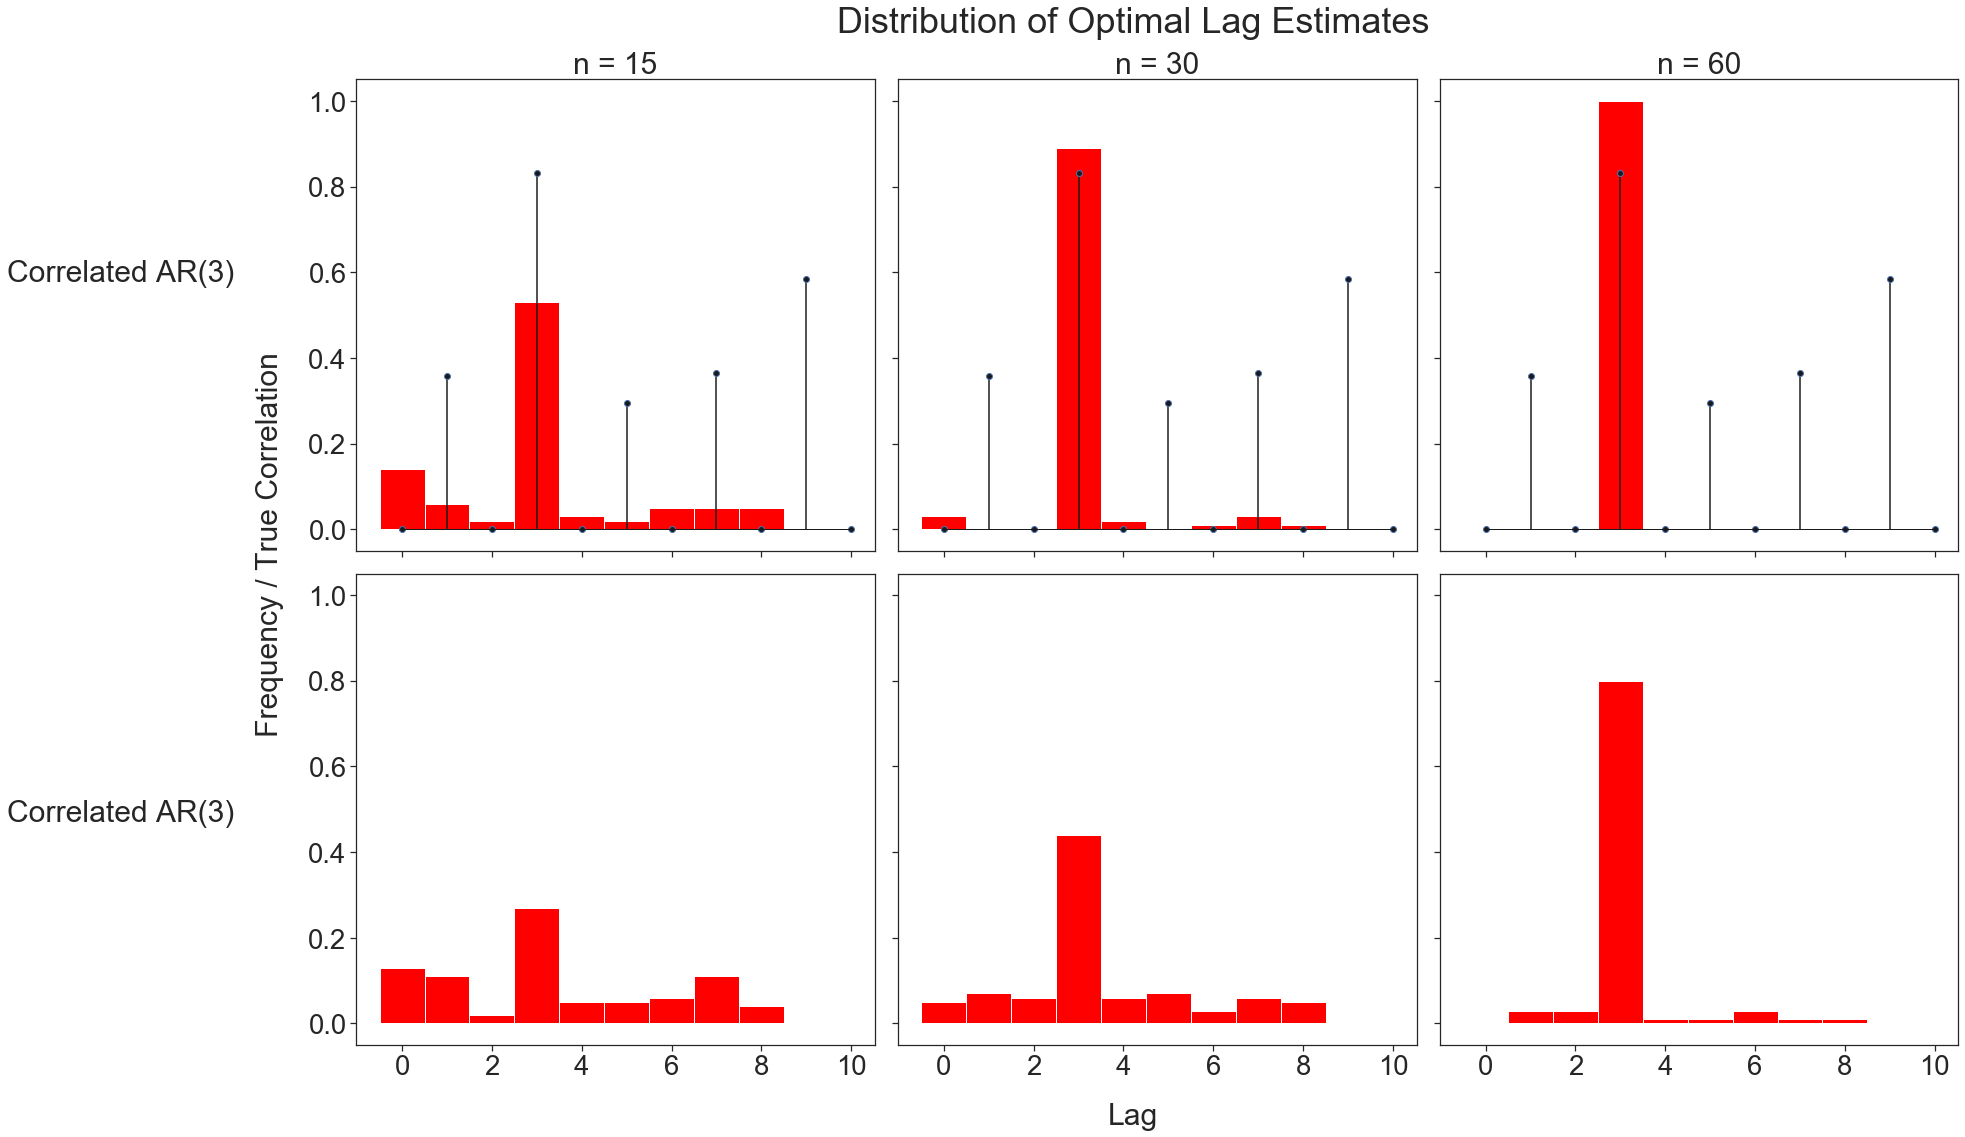

In [48]:
plot_figure()